<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Segmentation.png" width="400"/>

# Customer Segmentation: Estimate Individualized Responses to Incentives

Nowadays, business decision makers rely on estimating the causal effect of interventions to answer what-if questions about shifts in strategy, such as promoting specific product with discount, adding new features to a website or increasing investment from a sales team. However, rather than learning whether to take action for a specific intervention for all users, people are increasingly interested in understanding the different responses from different users to the two alternatives. Identifying the characteristics of users having the strongest response for the intervention could help make rules to segment the future users into different groups. This can help optimize the policy to use the least resources and get the most profit.

In this case study, we will use a personalized pricing example to explain how the [EconML](https://aka.ms/econml) and [DoWhy](https://github.com/py-why/dowhy) libraries could fit into this problem and provide robust and reliable causal solutions.

### Summary

1. [Background](#background)
2. [Data](#data)
3. [Create Causal Model and Identify Causal Effect with DoWhy](#identify)
4. [Get Causal Effects with EconML](#estimate)
5. [Test Estimate Robustness with DoWhy](#robustness)
    1. [Add Random Common Cause](#random-common-cause)
    2. [Add Unobserved Common Cause](#unobserved-common-cause)
    3. [Replace Treatment with a Random (Placebo) Variable](#placebo-variable)
    4. [Remove a Random Subset of the Data](#subset)
6. [Understand Treatment Effects with EconML](#interpret)
7. [Make Policy Decisions with EconML](#policy)
8. [Conclusions](#conclusion)




# Background <a id="background"></a>

<img src="https://cdn.pixabay.com/photo/2018/08/16/11/59/radio-3610287_960_720.png" width="400" />

The global online media market is growing fast over the years. Media companies are always interested in attracting more users into the market and encouraging them to buy more songs or become members. In this example, we'll consider a scenario where one experiment a media company is running is to give small discount (10%, 20% or 0) to their current users based on their income level in order to boost the likelihood of their purchase. The goal is to understand the **heterogeneous price elasticity of demand** for people with different income level, learning which users would respond most strongly to a small discount. Furthermore, their end goal is to make sure that despite decreasing the price for some consumers, the demand is raised enough to boost the overall revenue.

The EconML and DoWhy libraries complement each other in implementing this solution. On one hand, the DoWhy library can help [build a causal model, indentify the causal effect](#identify) and [test causal assumptions](#robustness). On the other hand, EconML‚Äôs `DML` based estimators can be used to take the discount variation in existing data, along with a rich set of user features, to [estimate heterogeneous price sensitivities](#estimate) that vary with multiple customer features. Then, the `SingleTreeCateInterpreter` provides a [presentation-ready summary](#interpret) of the key features that explain the biggest differences in responsiveness to a discount, and the `SingleTreePolicyInterpreter` recommends a [policy](#policy) on who should receive a discount in order to increase revenue (not only demand), which could help the company to set an optimal price for those users in the future.

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

# Data <a id="data"></a>


The dataset* has ~10,000 observations and includes 9 continuous and categorical variables that represent user's characteristics and online behaviour history such as age, log income, previous purchase, previous online time per week, etc. 

We define the following variables:

Feature Name|Type|Details 
:--- |:---|:--- 
**account_age** |W| user's account age
**age** |W|user's age
**avg_hours** |W| the average hours user was online per week in the past
**days_visited** |W| the average number of days user visited the website per week in the past
**friend_count** |W| number of friends user connected in the account 
**has_membership** |W| whether the user had membership
**is_US** |W| whether the user accesses the website from the US 
**songs_purchased** |W| the average songs user purchased per week in the past
**income** |X| user's income
**price** |T| the price user was exposed during the discount season (baseline price * small discount)
**demand** |Y| songs user purchased during the discount season

**To protect the privacy of the company, we use the simulated data as an example here. The data is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*


The treatment and outcome are generated using the following functions:
$$
T = 
\begin{cases}
  1 & \text{with } p=0.2,  \\
  0.9 & \text{with }p=0.3, & \text{if income}<1 \\
  0.8 & \text{with }p=0.5, \\
  \\
    1 & \text{with }p=0.7, \\
  0.9 & \text{with }p=0.2, & \text{if income}\ge1 \\
  0.8 & \text{with }p=0.1, \\
\end{cases}
$$


\begin{align}
\gamma(X) & = -3 - 14 \cdot \{\text{income}<1\} \\
\beta(X,W) & = 20 + 0.5 \cdot \text{avg_hours} + 5 \cdot \{\text{days_visited}>4\} \\
Y &= \gamma(X) \cdot T + \beta(X,W)
\end{align}



In [2]:
# Import the sample pricing data
# Nh·∫≠p d·ªØ li·ªáu m·∫´u

file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)


In [3]:
train_data

account_age  age  avg_hours  days_visited  friends_count  \
0               3   53   1.834234             2              8   
1               5   54   7.171411             7              9   
2               3   33   5.351920             6              9   
3               2   34   6.723551             0              8   
4               4   30   2.448247             5              8   
...           ...  ...        ...           ...            ...   
9995            2   56   6.095439             3             10   
9996            3   52   7.828183             7              5   
9997            1   27   6.527350             6              9   
9998            4   49   2.803943             6              9   
9999            5   35   9.334821             2              9   

      has_membership  is_US  songs_purchased    income  price     demand  
0                  1      1         4.903237  0.960863    1.0   3.917117  
1                  0      1         3.330161  0.732487    1.0  11.585706  
2                  0      1         3.036203  1.130937    1.0  24.675960  
3                  0      1         7.911926  0.929197    1.0   6.361776  
4                  1      0         7.148967  0.533527    0.8  12.624123  
...              ...    ...              ...       ...    ...        ...  
9995               0      0         7.406568  0.545599    0.8   9.447720  
9996               0      1         0.782374  0.944415    0.8  15.314092  
9997               0      1        10.926441  0.815953    1.0  11.263675  
9998               1      1         4.205016  0.504313    0.8  12.801971  
9999               0      1         2.971992  1.456270    1.0  21.667410  

[10000 rows x 11 columns]

In [4]:
# Data sample
train_data.head()

account_age  age  avg_hours  days_visited  friends_count  has_membership  \
0            3   53   1.834234             2              8               1   
1            5   54   7.171411             7              9               0   
2            3   33   5.351920             6              9               0   
3            2   34   6.723551             0              8               0   
4            4   30   2.448247             5              8               1   

   is_US  songs_purchased    income  price     demand  
0      1         4.903237  0.960863    1.0   3.917117  
1      1         3.330161  0.732487    1.0  11.585706  
2      1         3.036203  1.130937    1.0  24.675960  
3      1         7.911926  0.929197    1.0   6.361776  
4      0         7.148967  0.533527    0.8  12.624123

In [5]:
# Define estimator inputs
# ƒê·ªãnh nghƒ©a c√°c c√°c bi·∫øn ƒë·∫ßu v√†o cho ∆∞·ªõc t√≠nh 
train_data["log_demand"] = np.log(train_data["demand"])
train_data["log_price"] = np.log(train_data["price"])
#l·∫•y gi√° tr·ªã c·ªßa c·ªôt logarit c·ªßa demand ƒë·ªÉ l√†m bi·∫øn outcome
Y = train_data["log_demand"].values
#l·∫•y gi√° tr·ªã c·ªßa c·ªôt logarit c·ªßa price ƒë·ªÉ l√†m bi·∫øn treatment
T = train_data["log_price"].values
#l·∫•y gi√° tr·ªã c·ªôt income l√†m bi·∫øn ƒë·∫∑c tr∆∞ng 
X = train_data[["income"]].values  # features
#danh s√°ch bi·∫øn g√¢y nhi·ªÖu 
confounder_names = ["account_age", "age", "avg_hours", "days_visited", "friends_count", "has_membership", "is_US", "songs_purchased"]
#l·∫•y gi√° tr·ªã c·ªßa c√°c c·ªôt bi·∫øn g·∫´y nhi·ªÖu l√†m bi·∫øn g√¢y nhi·ªÖu
W = train_data[confounder_names].values

In [6]:
# Get test data
#l·∫•y d·ªØ li·ªáu ki·ªÉm tra 
# m·∫£ng g·ªìm 100 s·ªë t·ª´ 0 ƒë·∫øn 5 
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
#Chuy·ªÉn ƒë·ªïi m·∫£ng 2D th√†nh m·ªôt DataFrame v·ªõi t√™n c·ªôt l√† "income".
X_test_data = pd.DataFrame(X_test, columns=["income"])

In [7]:
X_test

array([[0.        ],
       [0.05050505],
       [0.1010101 ],
       [0.15151515],
       [0.2020202 ],
       [0.25252525],
       [0.3030303 ],
       [0.35353535],
       [0.4040404 ],
       [0.45454545],
       [0.50505051],
       [0.55555556],
       [0.60606061],
       [0.65656566],
       [0.70707071],
       [0.75757576],
       [0.80808081],
       [0.85858586],
       [0.90909091],
       [0.95959596],
       [1.01010101],
       [1.06060606],
       [1.11111111],
       [1.16161616],
       [1.21212121],
       [1.26262626],
       [1.31313131],
       [1.36363636],
       [1.41414141],
       [1.46464646],
       [1.51515152],
       [1.56565657],
       [1.61616162],
       [1.66666667],
       [1.71717172],
       [1.76767677],
       [1.81818182],
       [1.86868687],
       [1.91919192],
       [1.96969697],
       [2.02020202],
       [2.07070707],
       [2.12121212],
       [2.17171717],
       [2.22222222],
       [2.27272727],
       [2.32323232],
       [2.373

M·∫£ng 2D n√†y c√≥ th·ªÉ ƒë∆∞·ª£c s·ª≠ d·ª•ng l√†m d·ªØ li·ªáu ki·ªÉm tra trong c√°c m√¥ h√¨nh d·ª± ƒëo√°n ƒë·ªÉ xem c√°ch m√¥ h√¨nh d·ª± ƒëo√°n nhu c·∫ßu (demand) thay ƒë·ªïi theo thu nh·∫≠p (income).

# Create Causal Model and Identify Causal Effect with DoWhy <a id="identify"></a>

We define the causal assumptions with DoWhy. For example, we can include features we believe as confounders and features we think will influence the heterogeneity of the effect. With these assumptions defined, DoWhy can generate a causal graph for us, and use that graph to first identify the causal effect.

-> X√°c ƒë·ªãnh c√°c gi·∫£ ƒë·ªãnh nh√¢n qu·∫£ b·∫±ng DoWhy. DoWhy s·ª≠ d·ª•ng c√°c ƒë·∫∑c ƒëi·ªÉm: confounders and features cho r·∫±ng ·∫£nh h∆∞·ªüng ƒë·ªìng nh·∫•t ƒë·∫øn effect. DoWhy t·∫°o bi·ªÉu ƒë·ªì ƒë·ªÉ x√°c ƒë·ªãnh t√°c ƒë·ªông nh√¢n qu·∫£


In [8]:
# initiate an EconML cate estimator
#model_y s·ª≠ d·ª•ng gradientboostingRegressor ƒë·ªÉ d·ª± ƒëo√°n bi·∫øn outcome
#model_t s·ª≠ d·ª•ng m√¥ h√¨nh ƒë·ªÉ d·ª± ƒëo√°n bi·∫øn treatment
#B·ªô t·∫°o ƒë·∫∑c tr∆∞ng t·ª´ th∆∞ vi·ªán scikit-learn. N√≥ t·∫°o ra c√°c ƒë·∫∑c tr∆∞ng m·ªõi b·∫±ng c√°ch l·∫•y t·∫•t c·∫£ c√°c k·∫øt h·ª£p ƒëa th·ª©c b·∫≠c 2 c·ªßa c√°c bi·∫øn ƒë·∫ßu v√†o.
est = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [9]:
# fit through dowhy
#S·ª≠ d·ª•ng g√≥i statsmodels ƒë·ªÉ th·ª±c hi·ªán suy lu·∫≠n th·ªëng k√™
#∆∞·ªõc l∆∞·ª£ng t√°c ƒë·ªông nh√¢n qu·∫£ c·ªßa gi√° l√™n nhu c·∫ßu trong b·ªëi c·∫£nh c√≥ c√°c bi·∫øn g√¢y nhi·ªÖu v√† ƒë·∫∑c tr∆∞ng kh√°c
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"], feature_names=["income"],
               confounder_names=confounder_names, inference="statsmodels")

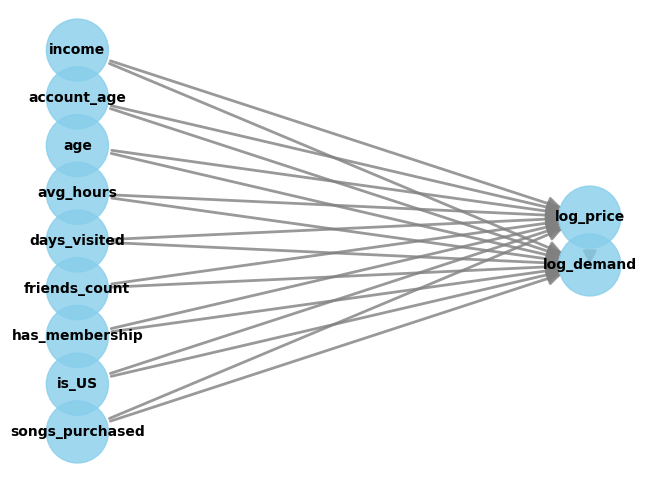

In [10]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model(layout=None) 

1. Kh·ªüi t·∫°o m·ªôt ∆∞·ªõc l∆∞·ª£ng CATE b·∫±ng LinearDML v·ªõi c√°c m√¥ h√¨nh GradientBoostingRegressor ƒë·ªÉ d·ª± ƒëo√°n bi·∫øn k·∫øt qu·∫£ v√† bi·∫øn ƒëi·ªÅu tr·ªã, v√† s·ª≠ d·ª•ng PolynomialFeatures ƒë·ªÉ t·∫°o c√°c ƒë·∫∑c tr∆∞ng b·∫≠c hai.
2. Hu·∫•n luy·ªán m√¥ h√¨nh n√†y v·ªõi d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã s·ª≠ d·ª•ng th∆∞ vi·ªán DoWhy.
3. Tr·ª±c quan h√≥a ƒë·ªì th·ªã nh√¢n qu·∫£ b·∫±ng c√°ch t·∫°o v√† hi·ªÉn th·ªã ƒë·ªì th·ªã.

In [11]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ‚Ü™
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ(E[log_demand|income,days_visited,friends_count,age,account_age,is ‚Ü™
d[log_price]                                                                   ‚Ü™

‚Ü™                                              
‚Ü™ _US,songs_purchased,has_‚ü®membership,‚ü©_hours])
‚Ü™                                              
Estimand assumption 1, Unconfoundedness: If U‚Üí{log_price} and U‚Üílog_demand then P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours,U) = P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


- lo·∫°i ƒë·∫°i l∆∞·ª£ng ∆∞·ªõc l∆∞·ª£ng l√† ATE
- ∆∞·ªõc l∆∞·ª£ng theo pp backdoor v·ªõi gi·∫£ ƒë·ªãnh l√† kh√¥ng c√≥ bi·∫øn g√¢y nhi·ªÖu

# Get Causal Effects with EconML <a id="estimate"></a>

Based on the identified causal effect above, we fit the model as follows using EconML:


\begin{align}
log(Y) & = \theta(X) \cdot log(T) + f(X,W) + \epsilon \\
log(T) & = g(X,W) + \eta
\end{align}


where $\epsilon, \eta$ are uncorrelated error terms. 


The models we fit here aren't an exact match for the data generation function above, but if they are a good approximation, they will allow us to create a good discount policy.  Although the model is misspecified, we hope to see that our `DML` based estimators can still capture the right trend of $\theta(X)$ and that the recommended policy beats other baseline policies (such as always giving a discount) on revenue.  Because of the mismatch between the data generating process and the model we're fitting, there isn't a single true $\theta(X)$ (the true elasticity varies with not only X but also T and W), but given how we generate the data above, we can still calculate the range of true $\theta(X)$ to compare against.

In [12]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)
# H√†m n√†y t√≠nh to√°n gi√° tr·ªã c·ªßa ùõæ(ùëã) d·ª±a tr√™n bi·∫øn ƒë·∫∑c tr∆∞ng income.
def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)
#H√†m n√†y t√≠nh to√°n gi√° tr·ªã c·ªßa ùõΩ(ùëã) d·ª±a tr√™n c√°c bi·∫øn ƒë·∫∑c tr∆∞ng avg_hours v√† days_visited
def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y
#H√†m n√†y t√≠nh to√°n nhu c·∫ßu (ùëå) d·ª±a tr√™n c√°c gi√° tr·ªã c·ªßa ùëá (bi·∫øn ƒëi·ªÅu tr·ªã - gi√°) v√† c√°c bi·∫øn ƒë·∫∑c tr∆∞ng kh√°c.

def true_te(x, n, stats):
    #s·ª≠ d·ª•ng sample ƒë·ªÉ l·∫•y m·∫´u ng·∫´u nhi√™n t·ª´ t·∫≠p train data
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)
#H√†m n√†y t√≠nh to√°n t√°c ƒë·ªông th·ª±c s·ª± (true treatment effect) c·ªßa gi√° l√™n nhu c·∫ßu cho m·ªôt m·ª©c thu nh·∫≠p c·ª• th·ªÉ (ùë•), d·ª±a tr√™n d·ªØ li·ªáu m·∫´u
#x: Gi√° tr·ªã thu nh·∫≠p ƒë·ªÉ ph√¢n chia d·ªØ li·ªáu.
#n: S·ªë l∆∞·ª£ng m·∫´u ƒë∆∞·ª£c l·∫•y t·ª´ t·∫≠p d·ªØ li·ªáu ban ƒë·∫ßu.
#stats: Ch·ªâ ƒë·ªãnh lo·∫°i th·ªëng k√™ (mean, median, ho·∫∑c m·ªôt percentile c·ª• th·ªÉ) ƒë·ªÉ t√≠nh to√°n t√°c ƒë·ªông.

In [13]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

truth_te_estimate: M·∫£ng ch·ª©a ∆∞·ªõc l∆∞·ª£ng trung b√¨nh c·ªßa t√°c ƒë·ªông ƒëi·ªÅu tr·ªã th·ª±c s·ª± cho t·ª´ng gi√° tr·ªã thu nh·∫≠p trong ùëãtest

truth_te_upper: M·∫£ng ch·ª©a m·ª©c tr√™n c·ªßa t√°c ƒë·ªông ƒëi·ªÅu tr·ªã th·ª±c s·ª± (percentile 95) cho t·ª´ng gi√° tr·ªã thu nh·∫≠p trong ùëãtest

truth_te_lower: M·∫£ng ch·ª©a m·ª©c d∆∞·ªõi c·ªßa t√°c ƒë·ªông ƒëi·ªÅu tr·ªã th·ª±c s·ª± (percentile 5) cho t·ª´ng gi√° tr·ªã thu nh·∫≠p trong ùëãtest

np.apply_along_axis(func1d, axis, arr, *args, **kwargs)

func1d: h√†m 1-D ƒë∆∞·ª£c s·ª≠ d·ª•ng cho m·∫£ng 2 chi·ªÅu X-test

axis: 

0: l·∫•y theo chi·ªÅu d·ªçc; 1: l·∫•y theo chi·ªÅu ngang c·ªßa m·∫£ng 1 chi·ªÅu

-1: chi·ªÅu cu·ªëi c√πng trong m·∫£ng ƒë·ªëi v·ªõi c√°c m·∫£ng tr√™n 2 chi·ªÅu

1: l·∫•y chi·ªÅu ngang v·ªõi m·∫£ng t·ª´ 2 chi·ªÅu tr·ªü l√™n

*args, **kwargs: tham s·ªë ƒë∆∞·ª£c truy·ªÅn th√™m v√†o h√†m ( ·ªü ƒë√¢y l√† 1000 v√† mean )

## Parametric heterogeneity ( tham s·ªë )
First of all, we can try to learn a **linear projection of the treatment effect** assuming a polynomial form of $\theta(X)$. We use the `LinearDML` estimator. Since we don't have any priors on these models, we use a generic gradient boosting tree estimators to learn the expected price and demand from the data.

In [14]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ‚Ü™
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ(E[log_demand|income,days_visited,friends_count,age,account_age,is ‚Ü™
d[log_price]                                                                   ‚Ü™

‚Ü™                                              
‚Ü™ _US,songs_purchased,has_‚ü®membership,‚ü©_hours])
‚Ü™                                              
Estimand assumption 1, Unconfoundedness: If U‚Üí{log_price} and U‚Üílog_demand then P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours,U) = P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours)

## Realized estimand
b: log_demand~log_price+income+days_visited+friends_count+age+a

M·ª•c ti√™u: ∆Ø·ªõc l∆∞·ª£ng t√°c ƒë·ªông nh√¢n qu·∫£ c·ªßa log_price l√™n log_demand s·ª≠ d·ª•ng LinearDML.

Ph∆∞∆°ng ph√°p: S·ª≠ d·ª•ng backdoor criterion v√† gi·∫£ ƒë·ªãnh kh√¥ng c√≥ g√¢y nhi·ªÖu (unconfoundedness assumption).

Mean value: Gi√° tr·ªã trung b√¨nh c·ªßa t√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ƒë∆∞·ª£c l√† -0.993. ƒêi·ªÅu n√†y c√≥ nghƒ©a l√† trung b√¨nh, m·ªôt ƒë∆°n v·ªã tƒÉng trong log_price d·∫´n ƒë·∫øn gi·∫£m 0.993 ƒë∆°n v·ªã trong log_demand.

In [15]:
# Get treatment effect and its confidence interval
#t√≠nh to√°n hi·ªáu ·ª©ng treatment kh√¥ng ƒë·ªìng nh·∫•t v·ªõi t·∫≠p ki·ªÉm tra l√† X_test (treatment effect) 
te_pred = est_dw.effect(X_test).flatten()
#t√≠nh to√°n kho·∫£ng tin c·∫≠y
te_pred_interval = est_dw.effect_interval(X_test)

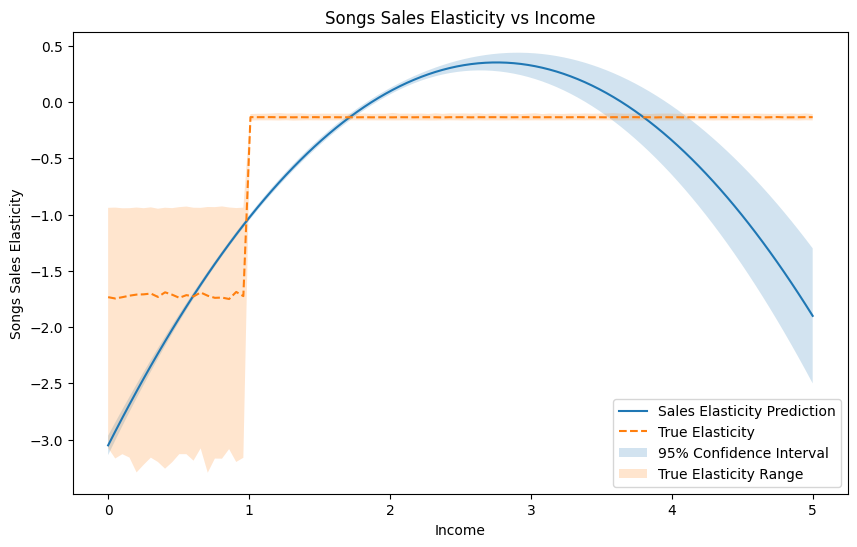

In [16]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
#ƒë·ªô co d√£n d·ª± ƒëo√°n
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
#ƒë·ªô co d√£n th·∫≠t s·ª±
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
#kho·∫£ng tin c·∫≠y
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
#kho·∫£ng co d√£n th·∫≠t s·ª±
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

ƒë·ªô co gi√£n √¢m v√† ng∆∞·ªùi d√¢n √≠t nh·∫°y c·∫£m h∆°n v·ªõi s·ª± thay ƒë·ªïi gi√° c·∫£ n·∫øu h·ªç c√≥ thu nh·∫≠p cao h∆°n.

From the plot above, it's clear to see that the true treatment effect is a **nonlinear** function of income, with elasticity around -1.75 when income is smaller than 1 and a small negative value when income is larger than 1. The model fits a quadratic treatment effect, which is not a great fit. But it still captures the overall trend: the elasticity is negative and people are less sensitive to the price change if they have higher income.

T·ª´ bi·ªÉu ƒë·ªì tr√™n, c√≥ th·ªÉ th·∫•y r√µ r·∫±ng hi·ªáu qu·∫£ can thi·ªáp th·ª±c s·ª± l√† m·ªôt h√†m phi tuy·∫øn t√≠nh c·ªßa thu nh·∫≠p, v·ªõi ƒë·ªô co gi√£n kho·∫£ng -1,75 khi thu nh·∫≠p nh·ªè h∆°n 1 v√† gi√° tr·ªã √¢m nh·ªè khi thu nh·∫≠p l·ªõn h∆°n 1. M√¥ h√¨nh ph√π h·ª£p v·ªõi c√°ch x·ª≠ l√Ω b·∫≠c hai hi·ªáu ·ª©ng n√†y kh√¥ng ph√π h·ª£p l·∫Øm. Nh∆∞ng n√≥ v·∫´n n·∫Øm b·∫Øt ƒë∆∞·ª£c xu h∆∞·ªõng chung: ƒë·ªô co gi√£n √¢m v√† ng∆∞·ªùi d√¢n √≠t nh·∫°y c·∫£m h∆°n v·ªõi s·ª± thay ƒë·ªïi gi√° c·∫£ n·∫øu h·ªç c√≥ thu nh·∫≠p cao h∆°n.

In [17]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=["income"])

<class 'econml.utilities.Summary'>
"""
                      Coefficient Results                      
===============================================================
         point_estimate stderr  zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------
income            2.468  0.071  34.553    0.0    2.328    2.608
income^2         -0.448  0.025 -18.261    0.0   -0.496   -0.399
                        CATE Intercept Results                       
=====================================================================
               point_estimate stderr  zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------------
cate_intercept          -3.05  0.044 -69.327    0.0   -3.137   -2.964
---------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = \phi(X)' coef_{ij} + cate\_intercept_{ij}$
where $\phi(X)$ is the output of the `featurizer`
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</sub>
"""

`LinearDML` estimator can also return the summary of the coefficients and intercept for the final model, including point estimates, p-values and confidence intervals. From the table above, we notice that $income$ has positive effect and ${income}^2$ has negative effect, and both of them are statistically significant.

C√¥ng c·ª• ∆∞·ªõc t√≠nh LinearDML c≈©ng c√≥ th·ªÉ tr·∫£ v·ªÅ b·∫£n t√≥m t·∫Øt c√°c h·ªá s·ªë v√† ƒëi·ªÉm ch·∫∑n cho m√¥ h√¨nh cu·ªëi c√πng, bao g·ªìm ∆∞·ªõc t√≠nh ƒëi·ªÉm, gi√° tr·ªã p v√† kho·∫£ng tin c·∫≠y. T·ª´ b·∫£ng tr√™n ta nh·∫≠n th·∫•y r·∫±ng $income$  c√≥ t√°c d·ª•ng t√≠ch c·ª±cv√† ${income}^2$ 
 c√≥ t√°c ƒë·ªông ti√™u c·ª±c v√† c·∫£ hai ƒë·ªÅu c√≥ √Ω nghƒ©a th·ªëng k√™.

## Nonparametric Heterogeneity ( phi tham s·ªë - phi tuy·∫øn t√≠nh )
Since we already know the true treatment effect function is nonlinear, let us fit another model using `CausalForestDML`, which assumes a fully **nonparametric estimation of the treatment effect**.

In [18]:
# initiate an EconML cate estimator
#s·ª≠ d·ª•ng m√¥ h√¨nh m√¥ h√¨nh causal forest
est_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
est_nonparam_dw = est_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"],
                                         feature_names=["income"], confounder_names=confounder_names, inference="blb")

In [19]:
# Get treatment effect and its confidence interval
te_pred = est_nonparam_dw.effect(X_test).flatten()
te_pred_interval = est_nonparam_dw.effect_interval(X_test)

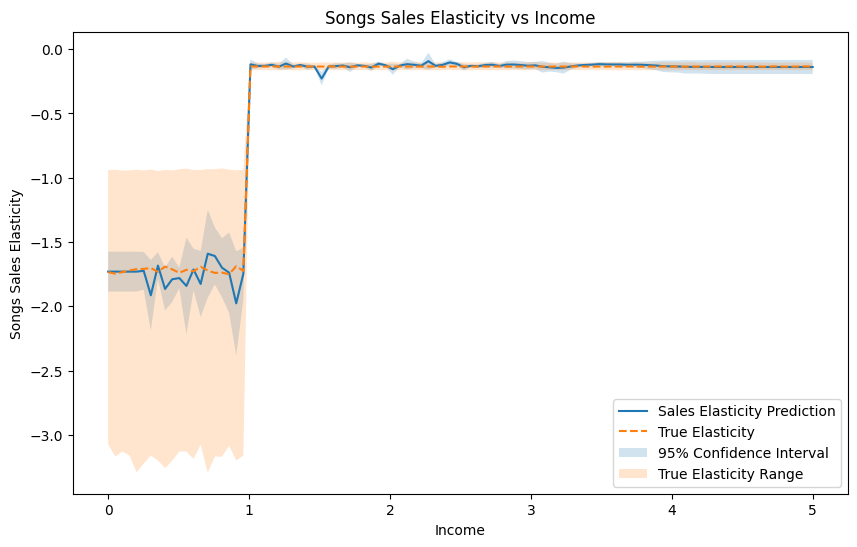

In [20]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

We notice that this model fits much better than the `LinearDML`, the 95% confidence interval correctly covers the true treatment effect estimate and captures the variation when income is around 1. Overall, the model shows that people with low income are much more sensitive to the price changes than higher income people.

Ch√∫ng t√¥i nh·∫≠n th·∫•y r·∫±ng m√¥ h√¨nh n√†y ph√π h·ª£p h∆°n nhi·ªÅu so v·ªõi LinearDML, kho·∫£ng tin c·∫≠y 95% bao h√†m ch√≠nh x√°c ∆∞·ªõc t√≠nh hi·ªáu qu·∫£ ƒëi·ªÅu tr·ªã th·ª±c s·ª± v√† n·∫Øm b·∫Øt ƒë∆∞·ª£c s·ª± thay ƒë·ªïi khi thu nh·∫≠p ·ªü kho·∫£ng 1. Nh√¨n chung, m√¥ h√¨nh cho th·∫•y nh·ªØng ng∆∞·ªùi c√≥ thu nh·∫≠p th·∫•p nh·∫°y c·∫£m h∆°n nhi·ªÅu v·ªõi gi√° thay ƒë·ªïi so v·ªõi nh·ªØng ng∆∞·ªùi c√≥ thu nh·∫≠p cao h∆°n.

# Test Estimate Robustness with DoWhy <a id="robustness"></a>

### Add Random Common Cause <a id="random-common-cause"></a>

How robust are our estimates to adding another confounder? We use DoWhy to test this!

In [21]:
res_random = est_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.9574050881634266
New effect:-0.9559879111880495
p value:0.31134390236917714



-ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng t√°c ƒë·ªông ƒëi·ªÅu tr·ªã (treatment effect) khi th√™m m·ªôt bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n (random common cause). 

Refute: Add a random common cause:
T√™n c·ªßa ph∆∞∆°ng ph√°p ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng, cho bi·∫øt m·ªôt bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n ƒë√£ ƒë∆∞·ª£c th√™m v√†o m√¥ h√¨nh.

Estimated effect: -0.9590993329875213: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu t·ª´ m√¥ h√¨nh l√† -0.959.

New effect: -0.9559298435174985: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi th√™m bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n l√† -0.956.

p value: 0.1353492332421919: Gi√° tr·ªã p ƒë·ªÉ ki·ªÉm tra s·ª± kh√°c bi·ªát gi·ªØa t√°c ƒë·ªông ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu v√† t√°c ƒë·ªông m·ªõi sau khi th√™m bi·∫øn g√¢y nhi·ªÖu. Gi√° tr·ªã p n√†y cho bi·∫øt m·ª©c ƒë·ªô √Ω nghƒ©a th·ªëng k√™ c·ªßa s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng.

ƒê·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng:

K·∫øt qu·∫£ cho th·∫•y t√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu (-0.959) v√† t√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi th√™m bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n (-0.956) kh√° g·∫ßn nhau.
S·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng n√†y l√† nh·ªè, cho th·∫•y r·∫±ng m√¥ h√¨nh ban ƒë·∫ßu c√≥ ƒë·ªô b·ªÅn v·ªØng t·ªët v·ªõi s·ª± b·ªï sung c·ªßa m·ªôt bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n.
Gi√° tr·ªã p (p value):

Gi√° tr·ªã p l√† 0.135, l·ªõn h∆°n m·ª©c √Ω nghƒ©a th√¥ng th∆∞·ªùng (th∆∞·ªùng l√† 0.05). ƒêi·ªÅu n√†y cho th·∫•y s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng kh√¥ng c√≥ √Ω nghƒ©a th·ªëng k√™.
N√≥i c√°ch kh√°c, vi·ªác th√™m m·ªôt bi·∫øn g√¢y nhi·ªÖu ng·∫´u nhi√™n kh√¥ng l√†m thay ƒë·ªïi ƒë√°ng k·ªÉ ∆∞·ªõc l∆∞·ª£ng t√°c ƒë·ªông ƒëi·ªÅu tr·ªã, cho th·∫•y m√¥ h√¨nh ban ƒë·∫ßu l√† kh√° b·ªÅn v·ªØng v·ªõi s·ª± hi·ªán di·ªán c·ªßa c√°c bi·∫øn g√¢y nhi·ªÖu.

### Add Unobserved Common Cause <a id="unobserved-common-cause"></a>

How robust are our estimates to unobserved confounders? Since we assume the model is under unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to test this!

In [22]:
res_unobserved = est_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.9574050881634266
New effect:-1.0112830226051355



Ph∆∞∆°ng ph√°p ƒë·ªÉ ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng b·∫±ng c√°ch th√™m m·ªôt bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c.

Refute: Add an Unobserved Common Cause: T√™n c·ªßa ph∆∞∆°ng ph√°p ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng, cho bi·∫øt m·ªôt bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c ƒë√£ ƒë∆∞·ª£c th√™m v√†o m√¥ h√¨nh.

Estimated effect: -0.9590993329875213: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu t·ª´ m√¥ h√¨nh l√† -0.959.

New effect: -1.0103946818313732: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi th√™m bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c l√† -1.010.

ƒê·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng:

K·∫øt qu·∫£ cho th·∫•y t√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu (-0.959) v√† t√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi th√™m bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c (-1.010) c√≥ s·ª± kh√°c bi·ªát ƒë√°ng k·ªÉ.
S·ª± kh√°c bi·ªát n√†y cho th·∫•y m√¥ h√¨nh ban ƒë·∫ßu nh·∫°y c·∫£m v·ªõi s·ª± hi·ªán di·ªán c·ªßa c√°c bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c, t·ª©c l√† ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu c√≥ th·ªÉ b·ªã sai l·ªách khi c√≥ c√°c bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c.
Gi√° tr·ªã p (p-value):

K·∫øt qu·∫£ n√†y kh√¥ng cung c·∫•p gi√° tr·ªã p, nh∆∞ng s·ª± kh√°c bi·ªát l·ªõn gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng cho th·∫•y r·∫±ng t√°c ƒë·ªông c·ªßa bi·∫øn g√¢y nhi·ªÖu kh√¥ng quan s√°t ƒë∆∞·ª£c l√† ƒë√°ng k·ªÉ.

### Replace Treatment with a Random (Placebo) Variable <a id="placebo-variable"></a>

What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be wildly different than our original estimate. We use DoWhy to investigate!

In [23]:
res_placebo = est_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.9574050881634266
New effect:-0.004581555221039909
p value:0.34869998592122775



 Ph∆∞∆°ng ph√°p ƒë·ªÉ ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng b·∫±ng c√°ch thay th·∫ø bi·∫øn ƒëi·ªÅu tr·ªã b·∫±ng m·ªôt bi·∫øn ng·∫´u nhi√™n.
Refute: Use a Placebo Treatment: T√™n c·ªßa ph∆∞∆°ng ph√°p ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng, cho bi·∫øt bi·∫øn ƒëi·ªÅu tr·ªã th·ª±c s·ª± ƒë√£ ƒë∆∞·ª£c thay th·∫ø b·∫±ng m·ªôt bi·∫øn ng·∫´u nhi√™n (placebo).

Estimated effect: -0.9590993329875213: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu t·ª´ m√¥ h√¨nh l√† -0.959.

New effect: -0.007289902897140782: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi thay th·∫ø bi·∫øn ƒëi·ªÅu tr·ªã b·∫±ng bi·∫øn ng·∫´u nhi√™n l√† -0.007.

p value: 0.19751083960102322: Gi√° tr·ªã p ƒë·ªÉ ki·ªÉm tra s·ª± kh√°c bi·ªát gi·ªØa t√°c ƒë·ªông ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu v√† t√°c ƒë·ªông m·ªõi sau khi thay th·∫ø bi·∫øn ƒëi·ªÅu tr·ªã. Gi√° tr·ªã p n√†y cho bi·∫øt m·ª©c ƒë·ªô √Ω nghƒ©a th·ªëng k√™ c·ªßa s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng.

√ù nghƒ©a c·ªßa k·∫øt qu·∫£

ƒê·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng:
K·∫øt qu·∫£ cho th·∫•y t√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu (-0.959) v√† t√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi thay th·∫ø bi·∫øn ƒëi·ªÅu tr·ªã b·∫±ng bi·∫øn ng·∫´u nhi√™n (-0.007) c√≥ s·ª± kh√°c bi·ªát r·∫•t l·ªõn.
S·ª± kh√°c bi·ªát l·ªõn n√†y cho th·∫•y r·∫±ng bi·∫øn ƒëi·ªÅu tr·ªã th·ª±c s·ª± c√≥ t√°c ƒë·ªông ƒë√°ng k·ªÉ ƒë·∫øn bi·∫øn k·∫øt qu·∫£, v√† m√¥ h√¨nh ƒë√£ ph√°t hi·ªán ƒë√∫ng t√°c ƒë·ªông n√†y.
Gi√° tr·ªã p (p-value):

Gi√° tr·ªã p l√† 0.198, l·ªõn h∆°n m·ª©c √Ω nghƒ©a th√¥ng th∆∞·ªùng (th∆∞·ªùng l√† 0.05). ƒêi·ªÅu n√†y cho th·∫•y s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng kh√¥ng c√≥ √Ω nghƒ©a th·ªëng k√™. Tuy nhi√™n, s·ª± kh√°c bi·ªát l·ªõn v·ªÅ gi√° tr·ªã ∆∞·ªõc l∆∞·ª£ng cho th·∫•y r·∫±ng t√°c ƒë·ªông c·ªßa bi·∫øn ƒëi·ªÅu tr·ªã th·ª±c s·ª± l√† r√µ r√†ng.
 

### Remove a Random Subset of the Data <a id="subset"></a>

Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [24]:
res_subset = est_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.9574050881634266
New effect:-0.9567321775826828
p value:0.4449868899566042



Ph∆∞∆°ng ph√°p ƒë·ªÉ ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng b·∫±ng c√°ch s·ª≠ d·ª•ng m·ªôt t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu. (80%)

Refute: Use a subset of data: T√™n c·ªßa ph∆∞∆°ng ph√°p ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng, cho bi·∫øt m√¥ h√¨nh ƒë√£ s·ª≠ d·ª•ng m·ªôt t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu ƒë·ªÉ ki·ªÉm tra ƒë·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng.

Estimated effect: -0.9590993329875213: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu t·ª´ m√¥ h√¨nh l√† -0.959.

New effect: -0.960728967372631: T√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi s·ª≠ d·ª•ng m·ªôt t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu l√† -0.961.

p value: 0.42889555114431355: Gi√° tr·ªã p ƒë·ªÉ ki·ªÉm tra s·ª± kh√°c bi·ªát gi·ªØa t√°c ƒë·ªông ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu v√† t√°c ƒë·ªông m·ªõi sau khi s·ª≠ d·ª•ng t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu. Gi√° tr·ªã p n√†y cho bi·∫øt m·ª©c ƒë·ªô √Ω nghƒ©a th·ªëng k√™ c·ªßa s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng.

√ù nghƒ©a c·ªßa k·∫øt qu·∫£
ƒê·ªô b·ªÅn v·ªØng c·ªßa ∆∞·ªõc l∆∞·ª£ng:

K·∫øt qu·∫£ cho th·∫•y t√°c ƒë·ªông ƒëi·ªÅu tr·ªã ∆∞·ªõc l∆∞·ª£ng ban ƒë·∫ßu (-0.959) v√† t√°c ƒë·ªông ƒëi·ªÅu tr·ªã m·ªõi sau khi s·ª≠ d·ª•ng m·ªôt t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu (-0.961) g·∫ßn nh∆∞ gi·ªëng nhau.
S·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng l√† r·∫•t nh·ªè, cho th·∫•y m√¥ h√¨nh c√≥ ƒë·ªô b·ªÅn v·ªØng t·ªët v√† c√≥ kh·∫£ nƒÉng t·ªïng qu√°t h√≥a tr√™n c√°c t·∫≠p con d·ªØ li·ªáu kh√°c nhau.
Gi√° tr·ªã p (p-value):

Gi√° tr·ªã p l√† 0.429, l·ªõn h∆°n m·ª©c √Ω nghƒ©a th√¥ng th∆∞·ªùng (th∆∞·ªùng l√† 0.05). ƒêi·ªÅu n√†y cho th·∫•y s·ª± kh√°c bi·ªát gi·ªØa hai ∆∞·ªõc l∆∞·ª£ng kh√¥ng c√≥ √Ω nghƒ©a th·ªëng k√™, cho th·∫•y r·∫±ng m√¥ h√¨nh c√≥ th·ªÉ t·ªïng qu√°t h√≥a t·ªët tr√™n c√°c t·∫≠p con ng·∫´u nhi√™n c·ªßa d·ªØ li·ªáu.

# Understand Treatment Effects with EconML <a id="interpret"></a>
EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users respond strongly to the discount and the in white users respond lightly to the discount.

EconML bao g·ªìm c√°c c√¥ng c·ª• di·ªÖn gi·∫£i ƒë·ªÉ hi·ªÉu r√µ h∆°n v·ªÅ hi·ªáu qu·∫£ ƒëi·ªÅu tr·ªã. Hi·ªáu qu·∫£ ƒëi·ªÅu tr·ªã c√≥ th·ªÉ ph·ª©c t·∫°p nh∆∞ng ƒë√¥i khi ch√∫ng t√¥i quan t√¢m ƒë·∫øn c√°c quy t·∫Øc ƒë∆°n gi·∫£n c√≥ th·ªÉ ph√¢n bi·ªát gi·ªØa ng∆∞·ªùi d√πng ph·∫£n h·ªìi t√≠ch c·ª±c, ng∆∞·ªùi d√πng gi·ªØ th√°i ƒë·ªô trung l·∫≠p v√† ng∆∞·ªùi d√πng ph·∫£n h·ªìi ti√™u c·ª±c v·ªõi nh·ªØng thay ƒë·ªïi ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t.

EconML `SingleTreeCateInterpreter` cung c·∫•p kh·∫£ nƒÉng t∆∞∆°ng t√°c b·∫±ng c√°ch ƒë√†o t·∫°o m·ªôt c√¢y quy·∫øt ƒë·ªãnh duy nh·∫•t v·ªÅ c√°c hi·ªáu ·ª©ng x·ª≠ l√Ω do b·∫•t k·ª≥ c√¥ng c·ª• ∆∞·ªõc t√≠nh EconML n√†o ƒë∆∞a ra. Trong h√¨nh b√™n d∆∞·ªõi, ch√∫ng ta c√≥ th·ªÉ th·∫•y ng∆∞·ªùi d√πng m√†u ƒë·ªè s·∫´m ph·∫£n ·ª©ng m·∫°nh m·∫Ω v·ªõi vi·ªác gi·∫£m gi√° v√† ng∆∞·ªùi d√πng m√†u tr·∫Øng ph·∫£n ·ª©ng nh·∫π v·ªõi vi·ªác gi·∫£m gi√°.

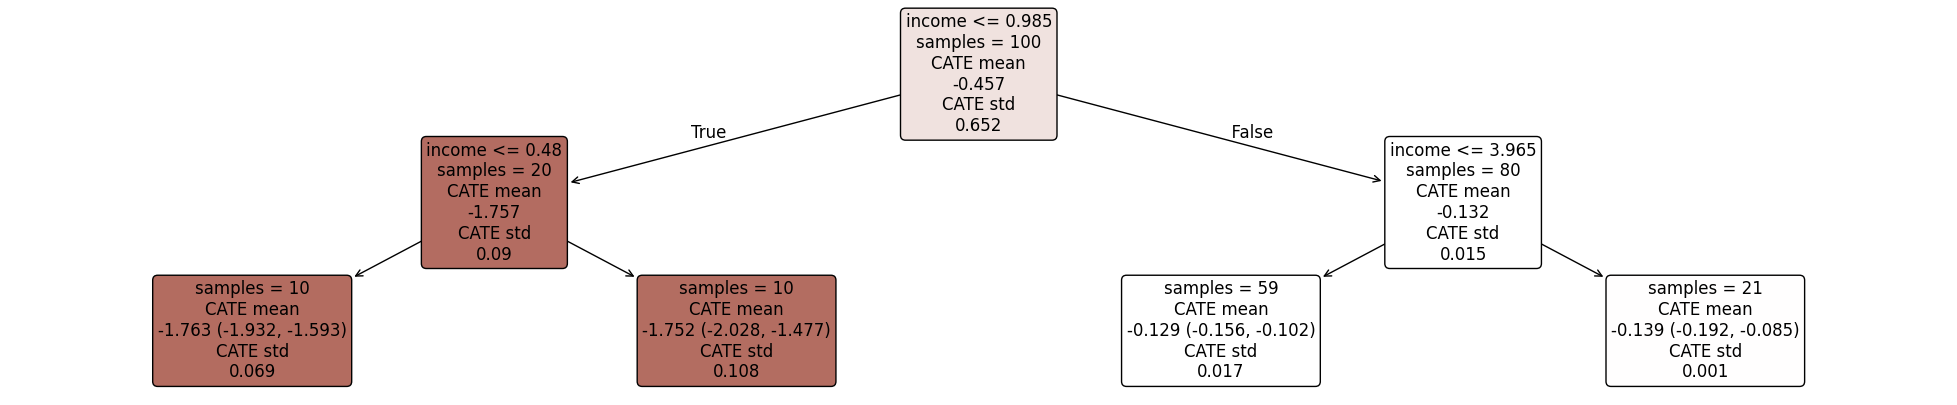

In [25]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_nonparam_dw, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["income"], fontsize=12)

Nh√≥m c√≥ thu nh·∫≠p th·∫•p:

Nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p nh·ªè h∆°n ho·∫∑c b·∫±ng 0.985 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh √¢m m·∫°nh h∆°n (-0.453). ƒêi·ªÅu n√†y cho th·∫•y r·∫±ng nh·ªØng ng∆∞·ªùi d√πng n√†y nh·∫°y c·∫£m h∆°n v·ªõi thay ƒë·ªïi gi√° v√† c√≥ xu h∆∞·ªõng gi·∫£m nhu c·∫ßu khi gi√° tƒÉng.
Trong nh√≥m n√†y, nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p nh·ªè h∆°n ho·∫∑c b·∫±ng 0.48 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh th·∫≠m ch√≠ c√≤n √¢m h∆°n (-1.802), cho th·∫•y m·ª©c ƒë·ªô nh·∫°y c·∫£m cao nh·∫•t v·ªõi thay ƒë·ªïi gi√°.

Nh√≥m c√≥ thu nh·∫≠p cao:
Nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p l·ªõn h∆°n 0.985 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh √≠t √¢m h∆°n (-0.116). ƒêi·ªÅu n√†y cho th·∫•y r·∫±ng nh·ªØng ng∆∞·ªùi d√πng n√†y √≠t nh·∫°y c·∫£m h∆°n v·ªõi thay ƒë·ªïi gi√° so v·ªõi nh√≥m c√≥ thu nh·∫≠p th·∫•p.
Trong nh√≥m n√†y, nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p l·ªõn h∆°n 3.359 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh g·∫ßn nh∆∞ kh√¥ng √¢m (-0.1).

ƒê·ªô l·ªách chu·∫©n:
ƒê·ªô l·ªách chu·∫©n (CATE std) ƒë∆∞·ª£c bao g·ªìm trong c√°c n√∫t cho th·∫•y m·ª©c ƒë·ªô bi·∫øn ƒë·ªông c·ªßa c√°c ∆∞·ªõc l∆∞·ª£ng t√°c ƒë·ªông ƒëi·ªÅu tr·ªã. ƒê·ªô l·ªách chu·∫©n th·∫•p cho th·∫•y ∆∞·ªõc l∆∞·ª£ng ·ªïn ƒë·ªãnh h∆°n trong nh√≥m ƒë√≥.

# Make Policy Decision with EconML <a id="policy"></a>
We want to make policy decisions to maximum the **revenue** instead of the demand. In this scenario,


\begin{align}
Rev & = Y \cdot T \\
    & = \exp^{log(Y)} \cdot T\\
    & = \exp^{(\theta(X) \cdot log(T) + f(X,W) + \epsilon)} \cdot T \\
    & = \exp^{(f(X,W) + \epsilon)} \cdot T^{(\theta(X)+1)}
\end{align}


With the decrease of price, revenue will increase only if $\theta(X)+1<0$. Thus, we set `sample_treatment_cast=-1` here to learn **what kinds of customers we should give a small discount to maximum the revenue**.

V·ªõi ƒëi·ªÅu ki·ªán ùúÉ(ùëã)+1<0:
Khi gi√° gi·∫£m, doanh thu s·∫Ω tƒÉng n·∫øu Œ∏(X)+1<0. ƒêi·ªÅu n√†y c√≥ nghƒ©a l√† t√°c ƒë·ªông ƒëi·ªÅu tr·ªã c√≥ ƒëi·ªÅu ki·ªán (CATE) ph·∫£i √¢m v√† ƒë·ªß l·ªõn ƒë·ªÉ l√†m cho bi·ªÉu th·ª©c  Œ∏(X)+1 nh·ªè h∆°n 0.

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. In the figure below we can see the model recommends to give discount for people with income less than $0.985$ and give original price for the others.

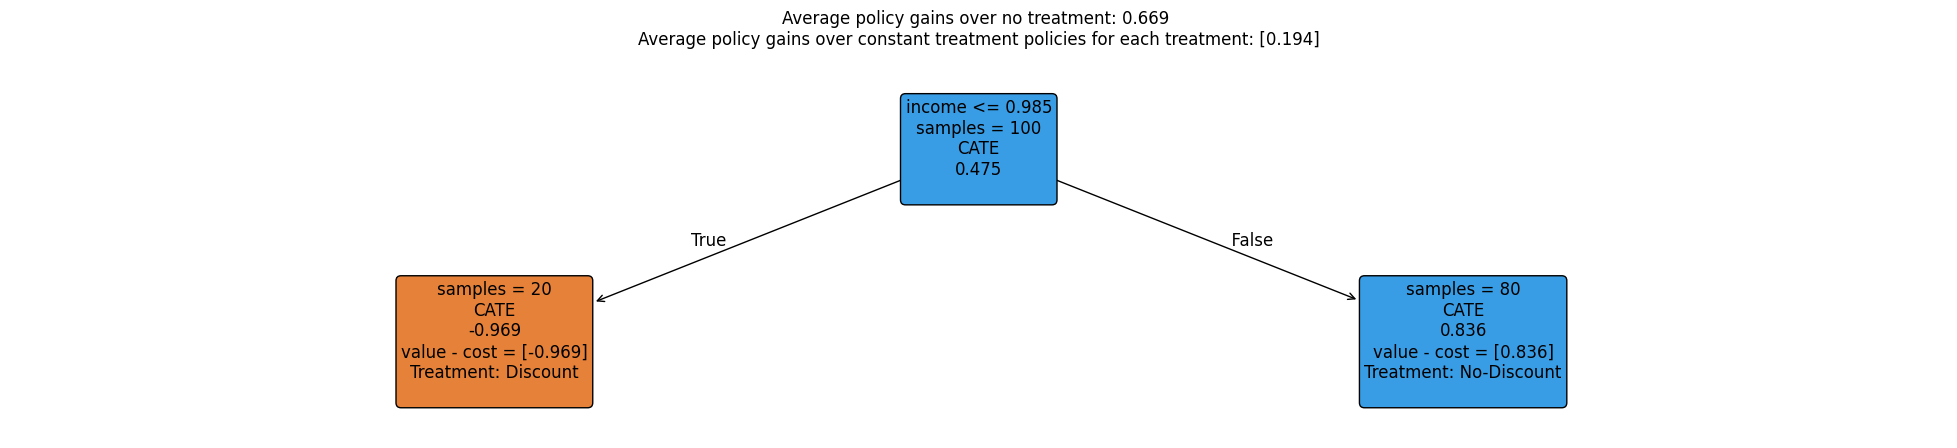

In [26]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est_nonparam_dw, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["income"], treatment_names=["Discount", "No-Discount"], fontsize=12)

s·ª≠ d·ª•ng c√¥ng c·ª• SingleTreePolicyInterpreter c·ªßa EconML ƒë·ªÉ ƒë∆∞a ra quy·∫øt ƒë·ªãnh ch√≠nh s√°ch nh·∫±m t·ªëi ƒëa h√≥a doanh thu.

Nh√≥m c√≥ thu nh·∫≠p th·∫•p:

Nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p nh·ªè h∆°n ho·∫∑c b·∫±ng 0.985 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh l√† 0.49.
Trong nh√≥m n√†y, nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p nh·ªè h∆°n ho·∫∑c b·∫±ng 0.985 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh √¢m m·∫°nh h∆°n (-1.018). ƒêi·ªÅu n√†y cho th·∫•y r·∫±ng nh√≥m n√†y n√™n ƒë∆∞·ª£c gi·∫£m gi√° ƒë·ªÉ t·ªëi ƒëa h√≥a doanh thu.

Nh√≥m c√≥ thu nh·∫≠p cao:

Nh·ªØng ng∆∞·ªùi d√πng c√≥ thu nh·∫≠p l·ªõn h∆°n 0.985 c√≥ t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh l√† 0.867.
Trong nh√≥m n√†y, t√°c ƒë·ªông ƒëi·ªÅu tr·ªã trung b√¨nh l√† d∆∞∆°ng (0.867), cho th·∫•y r·∫±ng nh√≥m n√†y kh√¥ng n√™n ƒë∆∞·ª£c gi·∫£m gi√° ƒë·ªÉ t·ªëi ƒëa h√≥a doanh thu.


Now, let us compare our policy with other baseline policies! Our model says which customers to give a small discount to, and for this experiment, we will set a discount level of 10% for those users. Because the model is misspecified we would not expect good results with large discounts. Here, because we know the ground truth, we can evaluate the value of this policy.

B√¢y gi·ªù, ch√∫ng ta h√£y so s√°nh ch√≠nh s√°ch c·ªßa ch√∫ng t√¥i v·ªõi c√°c ch√≠nh s√°ch c∆° b·∫£n kh√°c! M√¥ h√¨nh c·ªßa ch√∫ng t√¥i cho bi·∫øt nh·ªØng kh√°ch h√†ng n√†o s·∫Ω ƒë∆∞·ª£c gi·∫£m gi√° m·ªôt ch√∫t v√† ƒë·ªëi v·ªõi th·ª≠ nghi·ªám n√†y, ch√∫ng t√¥i s·∫Ω ƒë·∫∑t m·ª©c chi·∫øt kh·∫•u l√† 10% cho nh·ªØng ng∆∞·ªùi d√πng ƒë√≥. V√¨ m√¥ h√¨nh b·ªã x√°c ƒë·ªãnh sai n√™n ch√∫ng t√¥i kh√¥ng mong ƒë·ª£i k·∫øt qu·∫£ t·ªët v·ªõi m·ª©c chi·∫øt kh·∫•u l·ªõn. ·ªû ƒë√¢y, v√¨ ch√∫ng ta bi·∫øt s·ª± th·∫≠t c∆° b·∫£n n√™n ch√∫ng ta c√≥ th·ªÉ ƒë√°nh gi√° gi√° tr·ªã c·ªßa ch√≠nh s√°ch n√†y.

In [27]:
# define function to compute revenue
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

H√†m revenue_fn t√≠nh to√°n doanh thu b·∫±ng c√°ch s·ª≠ d·ª•ng c√°c m·ª©c gi·∫£m gi√° v√† ch√≠nh s√°ch gi·∫£m gi√° ƒë·ªÉ x√°c ƒë·ªãnh gi√° sau gi·∫£m gi√° cho t·ª´ng kh√°ch h√†ng, sau ƒë√≥ t√≠nh to√°n nhu c·∫ßu t∆∞∆°ng ·ª©ng v√† cu·ªëi c√πng l√† doanh thu. H√†m n√†y r·∫•t h·ªØu √≠ch trong vi·ªác ƒë√°nh gi√° hi·ªáu qu·∫£ c·ªßa c√°c ch√≠nh s√°ch gi·∫£m gi√° kh√°c nhau v√† t·ªëi ∆∞u h√≥a doanh thu.

In [28]:
policy_dic = {}
# our policy above
policy = intrp.treat(X)
#C1:Ch√≠nh s√°ch ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t: T√≠nh doanh thu b·∫±ng c√°ch kh√¥ng gi·∫£m gi√° cho nh√≥m ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t gi·∫£m gi√° v√† gi·∫£m 10% cho nh√≥m kh√¥ng ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t gi·∫£m gi√°.
policy_dic["Our Policy"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, policy))

## previous strategy
#C2: Chi·∫øn l∆∞·ª£c tr∆∞·ªõc ƒë√¢y: T√≠nh doanh thu trung b√¨nh theo chi·∫øn l∆∞·ª£c hi·ªán t·∫°i, d·ª±a tr√™n gi√° v√† nhu c·∫ßu hi·ªán t·∫°i c·ªßa d·ªØ li·ªáu.
policy_dic["Previous Strategy"] = np.mean(train_data["price"] * train_data["demand"])

## give everyone discount
#C3: Gi·∫£m gi√° cho t·∫•t c·∫£ m·ªçi ng∆∞·ªùi: T√≠nh doanh thu b·∫±ng c√°ch gi·∫£m 10% cho t·∫•t c·∫£ kh√°ch h√†ng.
policy_dic["Give Everyone Discount"] = np.mean(revenue_fn(train_data, 0.1, 0, 1, np.ones(len(X))))

## don't give discount
#C4: Kh√¥ng gi·∫£m gi√° cho ai
policy_dic["Give No One Discount"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, np.ones(len(X))))

## follow our policy, but give -10% discount for the group doesn't recommend to give discount
# C5:T√≠nh doanh thu b·∫±ng c√°ch gi·∫£m gi√° -10% (tƒÉng gi√°) cho nh√≥m ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t kh√¥ng gi·∫£m gi√° v√† gi·∫£m 10% cho nh√≥m ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t gi·∫£m gi√°
policy_dic["Our Policy + Give Negative Discount for No-Discount Group"] = np.mean(revenue_fn(train_data, -0.1, 0.1, 1, policy))

## give everyone -10% discount
#C6: TƒÉng gi√° t·∫•t c·∫£ m·ªçi ng∆∞·ªùi 10%
policy_dic["Give Everyone Negative Discount"] = np.mean(revenue_fn(train_data, -0.1, 0, 1, np.ones(len(X))))

In [29]:
# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=["Revenue"])
res["Rank"] = res["Revenue"].rank(ascending=False)
res

Revenue  Rank
Our Policy                                          14.686241   2.0
Previous Strategy                                   14.349342   4.0
Give Everyone Discount                              13.774469   6.0
Give No One Discount                                14.294606   5.0
Our Policy + Give Negative Discount for No-Disc...  15.564411   1.0
Give Everyone Negative Discount                     14.612670   3.0

**We beat the baseline policies!** Our policy gets the highest revenue except for the one raising the price for the No-Discount group. That means our currently baseline price is low, but the way we segment the user does help increase the revenue!

ƒêi·ªÅu ƒë√≥ c√≥ nghƒ©a l√† m·ª©c gi√° c∆° b·∫£n hi·ªán t·∫°i c·ªßa ch√∫ng t√¥i th·∫•p nh∆∞ng c√°ch ch√∫ng t√¥i ph√¢n kh√∫c ng∆∞·ªùi d√πng s·∫Ω gi√∫p tƒÉng doanh thu!

# Conclusions <a id="conclusion"></a>

In this notebook, we have demonstrated the power of using EconML and DoWhy to:

* Estimate the treatment effect correctly even the model is misspecified
* Test causal assumptions and investigate the robustness of the resulting estimates
* Interpret the resulting individual-level treatment effects
* Make the policy decision beats the previous and baseline policies

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/py-why/EconML) or our [documentation](https://econml.azurewebsites.net/). 

To learn more about what DoWhy can do for you, visit the [GitHub page](https://github.com/py-why/dowhy) or [documentation](https://www.pywhy.org/dowhy/).
